In [361]:
import pandas as pd

RAW_DATA_PATH = "../data/raw/KSI.csv"

df = pd.read_csv(RAW_DATA_PATH)

In [365]:
from sklearn.base import TransformerMixin, BaseEstimator


class FillMissing(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, value_col):
        self.group_col = group_col
        self.value_col = value_col
    
    def fit(self):
        return self
        
    def transform(self, X):
        # Separate the columns that will be updated
        update_cols = [self.group_col, self.value_col]
        
        # Create a copy of the dataframe to avoid modifying the original
        filled = X.copy()
        
        # Group the data by "ACCNUM" and fill in missing values
        filled[update_cols] = filled.groupby(self.group_col)[update_cols].ffill().bfill()
        
        return filled

In [366]:
trans = FillMissing('ACCNUM', 'VEHTYPE')
filled = trans.transform(new_df)

In [367]:
filled['VEHTYPE'].isna().sum()

0

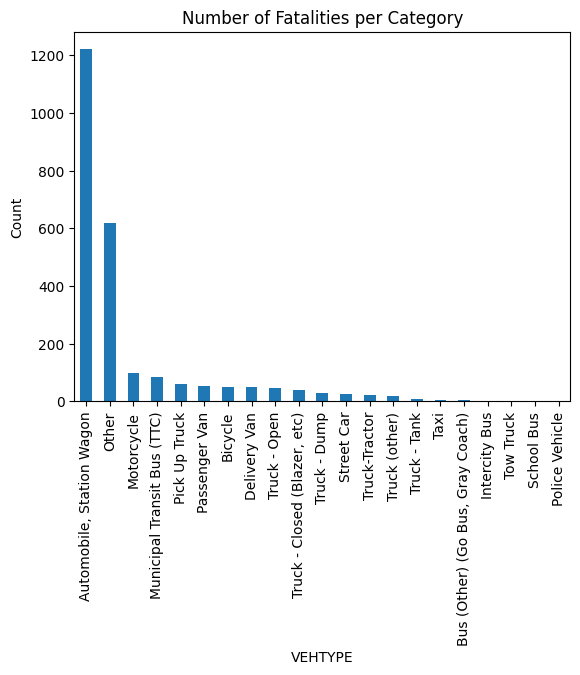

In [368]:
import matplotlib.pyplot as plt
# create a filtered dataframe where the Label is equal to 'fatal'
fatal_df = filled[filled['ACCLASS'] == 'Fatal']

# plot a histogram of the number of values per category
fatal_df['VEHTYPE'].value_counts().plot(kind='bar', width=0.5)
plt.xlabel('VEHTYPE')
plt.ylabel('Count')
plt.title('Number of Fatalities per Category')
plt.xticks(rotation=90)
plt.show()


## Yes / No Transformers

In [369]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

steps = [('imputer', SimpleImputer(strategy='constant',fill_value='No')),
         ('onehot', OneHotEncoder(drop='first',sparse=False))]

yes_no_pipe = Pipeline(steps)

## Time transformer

In [370]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np

class TimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def transform(self, X):
        #return [int(row // 100) for row in X]
        return X.apply(lambda row: (row//100) + 1 if int(str(row)[-2:]) > 30 else row//100)
        #return pd.Dataframe([(row//100) + 1 if int(str(row)[-2:]) > 30 else row//100 for row in X.values])

    def fit(self, X):
        return self
    

## Date transformer

In [372]:
from sklearn.base import BaseEstimator, TransformerMixin 
from datetime import datetime

class DayofWeekMonth(BaseEstimator, TransformerMixin): 
    def __init__(self): 
        #self.result = pd.DataFrame()
        pass 
    
    def fit(self,X): 
        return self 
    
    def transform(self, X): 
        print(type(X))
        date = pd.to_datetime(X.squeeze(), format='%Y/%m/%d')
        #date = X.apply(lambda val: datetime.strptime(val[:10], '%Y/%m/%d'))
        #print(date)
        result = pd.DataFrame()
        result['DAY'] = date.apply(lambda x: datetime.weekday(x))
        result['MONTH'] = date.apply(lambda x: x.month)
        return result

day = DayofWeekMonth() 
output = day.transform(df['DATE'])
print(output)
output['ACCLASS'] = df['ACCLASS']

<class 'pandas.core.series.Series'>
       DAY  MONTH
0        6      1
1        6      1
2        6      6
3        6      1
4        6      1
...    ...    ...
17483    4     10
17484    4     10
17485    4     10
17486    4     10
17487    5     10

[17488 rows x 2 columns]


## Fatal accidents per month

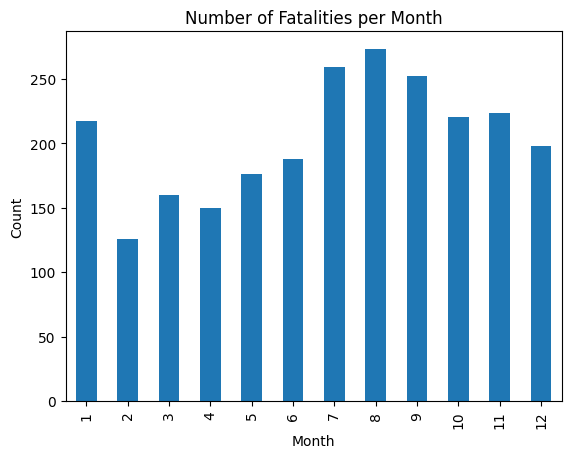

In [373]:
import matplotlib.pyplot as plt
# create a filtered dataframe where the Label is equal to 'fatal'
fatal_df = output[output['ACCLASS'] == 'Fatal']

# plot a histogram of the number of values per hour
fatal_df['MONTH'].value_counts().sort_index(ascending=True).plot(kind='bar', width=0.5)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of Fatalities per Month')
plt.xticks(rotation=90)
plt.show()

## Fatal accidents per weekday

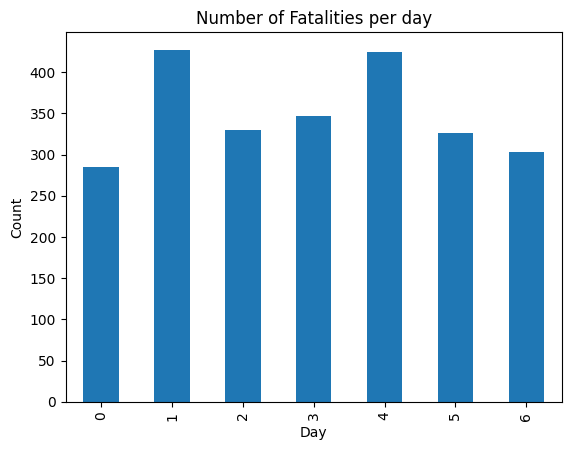

In [374]:
import matplotlib.pyplot as plt
# create a filtered dataframe where the Label is equal to 'fatal'
fatal_df = output[output['ACCLASS'] == 'Fatal']

# plot a histogram of the number of values per hour
fatal_df['DAY'].value_counts().sort_index(ascending=True).plot(kind='bar', width=0.5)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Number of Fatalities per day')
plt.xticks(rotation=90)
plt.show()

In [375]:
categorical_index = df.dtypes[df.dtypes == 'object'].index
categorical = df[categorical_index]
unique_count = categorical.nunique()
indeces = [i for i in categorical_index if df[i].nunique() == 1]
print(indeces)

['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']


In [381]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

transformers = [('yes', yes_no_pipe, indeces),
                ('time', TimeTransformer(), ['TIME']),
                ('date', DayofWeekMonth(), ['DATE']),
                ('type', SimpleImputer(strategy='constant', fill_value='unknow'), ['VEHTYPE', 'ROAD_CLASS', 'LOCCOORD', 'INVTYPE']),
                ('fill', SimpleImputer(strategy='most_frequent'), ['IMPACTYPE','ACCLASS', 'INVTYPE', 'VISIBILITY', 'RDSFCOND', 'TRAFFCTL']),
                ('scaler', StandardScaler(), ['LATITUDE', 'LONGITUDE', 'YEAR']),
                ('class', 'passthrough', ['ACCLASS', 'INVAGE', 'LIGHT'])]
ct = ColumnTransformer(transformers, remainder='drop')

result = ct.fit_transform(df)
transformed_df = pd.DataFrame(result)
transformed_df.head(10)



<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,Passenger,Clear,Wet,No Control,-0.195057,0.738865,-1.466431,Non-Fatal Injury,50 to 54,Dark
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,Passenger,Clear,Wet,No Control,-0.195057,0.738865,-1.466431,Non-Fatal Injury,15 to 19,Dark
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Passenger,Clear,Dry,No Control,-0.770734,-1.428471,-1.466431,Non-Fatal Injury,15 to 19,Dusk
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,Driver,Clear,Wet,No Control,-0.195057,0.738865,-1.466431,Non-Fatal Injury,55 to 59,Dark
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,Passenger,Clear,Wet,No Control,-0.195057,0.738865,-1.466431,Non-Fatal Injury,20 to 24,Dark
5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Vehicle Owner,Clear,Dry,Stop Sign,0.595943,1.077619,-1.466431,Non-Fatal Injury,unknown,Daylight
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,Passenger,Clear,Wet,No Control,-0.195057,0.738865,-1.466431,Non-Fatal Injury,15 to 19,Dark
7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Driver,Clear,Dry,Stop Sign,0.595943,1.077619,-1.466431,Non-Fatal Injury,45 to 49,Daylight
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,Passenger,Clear,Wet,No Control,-0.195057,0.738865,-1.466431,Non-Fatal Injury,20 to 24,Dark
9,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Cyclist,Clear,Dry,Stop Sign,0.595943,1.077619,-1.466431,Non-Fatal Injury,30 to 34,Daylight
